In [1]:
#2024.11.30

import pandas as pd 
import numpy as np
import gc
from matplotlib import pyplot as plt 

plt.rcParams["font.family"] = "Arial"  # Set global font to Arial

dfrac = pd.read_csv(r'./RACs.csv')                  # all MOFs including the theoretical ones
dfgeo = pd.read_csv(r'./geometric_properties.csv')
dfX = pd.read_csv(r'./20MOFX_right_mixed.csv')

In [2]:
dfrac_EMOF=dfrac.iloc[list(np.where(dfrac['DB_num']=='DB14')[0])+list(np.where(dfrac['DB_num']=='DB12')[0])]    # experimentally available MOFs
dfgeo_EMOF=dfgeo.iloc[list(np.where(dfgeo['DB_num']=='DB14')[0])+list(np.where(dfgeo['DB_num']=='DB12')[0])]

In [3]:
#remove unuseful columns
dfrac = dfrac.iloc[:, 1:-10]
dfgeo = dfgeo.iloc[:, 1:-4]
dfrac_EMOF = dfrac_EMOF.iloc[:, 1:-10]
dfgeo_EMOF = dfgeo_EMOF.iloc[:, 1:-4]

In [4]:
# Assuming you have two DataFrames df and dfg with a common column 'filename'
# Merging the DataFrames on 'filename' with inner join to keep only common entries
merged_df = pd.merge(dfrac, dfgeo, on='filename', how='inner')
merged_df_EMOF = pd.merge(dfrac_EMOF, dfgeo_EMOF, on='filename', how='inner')
del dfrac  # Delete the DataFrame
del dfgeo  # Delete the DataFrame
del dfrac_EMOF  # Delete the DataFrame
del dfgeo_EMOF  # Delete the DataFrame
gc.collect()  # Run garbage collection

0

In [5]:
#Remove the columns that has low variance
from sklearn.preprocessing import StandardScaler
import numpy as np

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(inplace=True)
merged_df_EMOF.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df_EMOF.dropna(inplace=True)

# make sure all the columns are numerical values
# merged_df = merged_df.select_dtypes(include=[np.number])

print(merged_df.shape)

# standardize
scaler = StandardScaler()
scaler.fit(merged_df.drop(columns=['filename']))
# convert the raw data using the standardizing method
scaled_merged_df = scaler.transform(merged_df.drop(columns=['filename']))  #all MOFs
MOF_index = dfX['MOF_index']
MOF_name = dfX['MOF']
dfX = dfX[merged_df.drop(columns=['filename']).columns]
scaled_dfX = scaler.transform(dfX)   #MOFs used in this study
dfEMOF = merged_df_EMOF[merged_df.drop(columns=['filename']).columns]  #experimentally available MOFs
scaled_dfEMOF = scaler.transform(dfEMOF)
# data standardization
df_standardized = pd.DataFrame(scaled_merged_df, columns=merged_df.drop(columns=['filename']).columns)
print(df_standardized.shape)
dfX_standardized = pd.DataFrame(scaled_dfX, columns=dfX.columns)
print(dfX_standardized.shape)
dfEMOF_standardized = pd.DataFrame(scaled_dfEMOF, columns=dfEMOF.columns)
print(dfEMOF_standardized.shape)

# del merged_df  # Delete the DataFrame
# gc.collect()  # Run garbage collection

# Remove the columns that has low variance
column_to_keep = (df_standardized.std() > 0) # a number that can be ajusted
df_standardized = df_standardized.loc[:, column_to_keep]  
dfX_standardized = dfX_standardized.loc[:, column_to_keep]  
dfEMOF_standardized = dfEMOF_standardized.loc[:, column_to_keep]
print(df_standardized.shape)
print(dfX_standardized.shape)
print(dfEMOF_standardized.shape)

(472494, 200)
(472494, 199)
(28, 199)
(11345, 199)
(472494, 171)
(28, 171)
(11345, 171)


In [6]:
#Test if factor analysis is suitable
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# # removing low variance columns
# df_standardized = df_standardized.loc[:, df_standardized.std() > 0.05]  # adjustable number

# examining feasibility using some figure of merits
chi_square_value, p_value = calculate_bartlett_sphericity(df_standardized.values)
kmo_all, kmo_model = calculate_kmo(df_standardized.values)

# the results
print("Bartlett's Test Value:", chi_square_value, "P-value:", p_value)
print("KMO Test Value:", kmo_model)


c:\ProgramData\anaconda3\envs\pymc_env\Lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
c:\ProgramData\anaconda3\envs\pymc_env\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Bartlett's Test Value: inf P-value: 0.0
KMO Test Value: 0.8350236044032986


c:\ProgramData\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


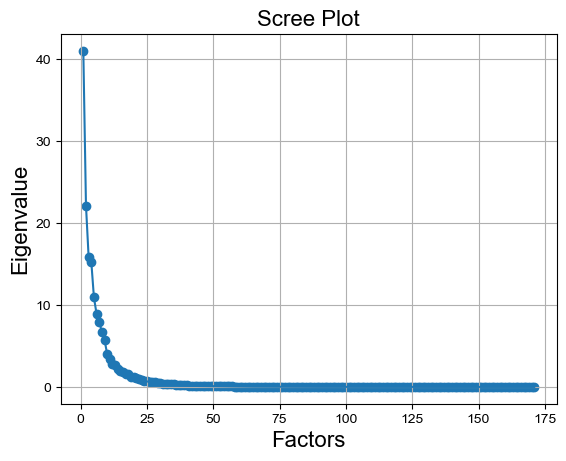

45


In [7]:
from matplotlib import pyplot as plt
# select the number of factors
fa = FactorAnalyzer(rotation=None, n_factors=3, method='minres')
fa.fit(df_standardized.values)

# factor loadings
loadings = fa.loadings_
# print(loadings)

# Scree plot for determining the number of factors

ev, v = fa.get_eigenvalues()
plt.scatter(range(1, df_standardized.shape[1]+1), ev)
plt.plot(range(1, df_standardized.shape[1]+1), ev)
plt.title('Scree Plot', fontsize=16)
plt.xlabel('Factors',fontsize=16)
plt.ylabel('Eigenvalue',fontsize=16)
plt.grid()
plt.show()
#selected the number of factors to consider
consider_threshold = 0.1
Num_factor_selected = sum(ev>consider_threshold)
print(Num_factor_selected)

In [8]:
# initializing the factor
fa = FactorAnalyzer(n_factors=Num_factor_selected, rotation='varimax')  # n_factors is the number of factors，adjustable
# fa = FactorAnalyzer(n_factors=Num_factor_selected, rotation=None)  # n_factors is the number of factors，adjustable
# factor analysis
fa.fit(df_standardized.values)  #on all MOFs

# get factor loadings
factor_loadings = fa.loadings_

# convert loadings to DataFrame
columns = [f'Factor{i+1}' for i in range(factor_loadings.shape[1])]
loadings_df = pd.DataFrame(factor_loadings, index=df_standardized.columns, columns=columns)

c:\ProgramData\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
#calculate the Bartlett scores
n_factors = factor_loadings.shape[1]
lambda_ = 0.001  # regularization parameter
I = np.eye(fa.corr_.shape[0])  
model_implied_cov_inv = np.linalg.pinv(fa.corr_+I)
factor_score_coefficients = np.linalg.pinv(factor_loadings.T @ model_implied_cov_inv @ factor_loadings) @ factor_loadings.T @ model_implied_cov_inv
factor_score_coefficients_df = pd.DataFrame(factor_score_coefficients.T, index=df_standardized.columns, columns=columns)

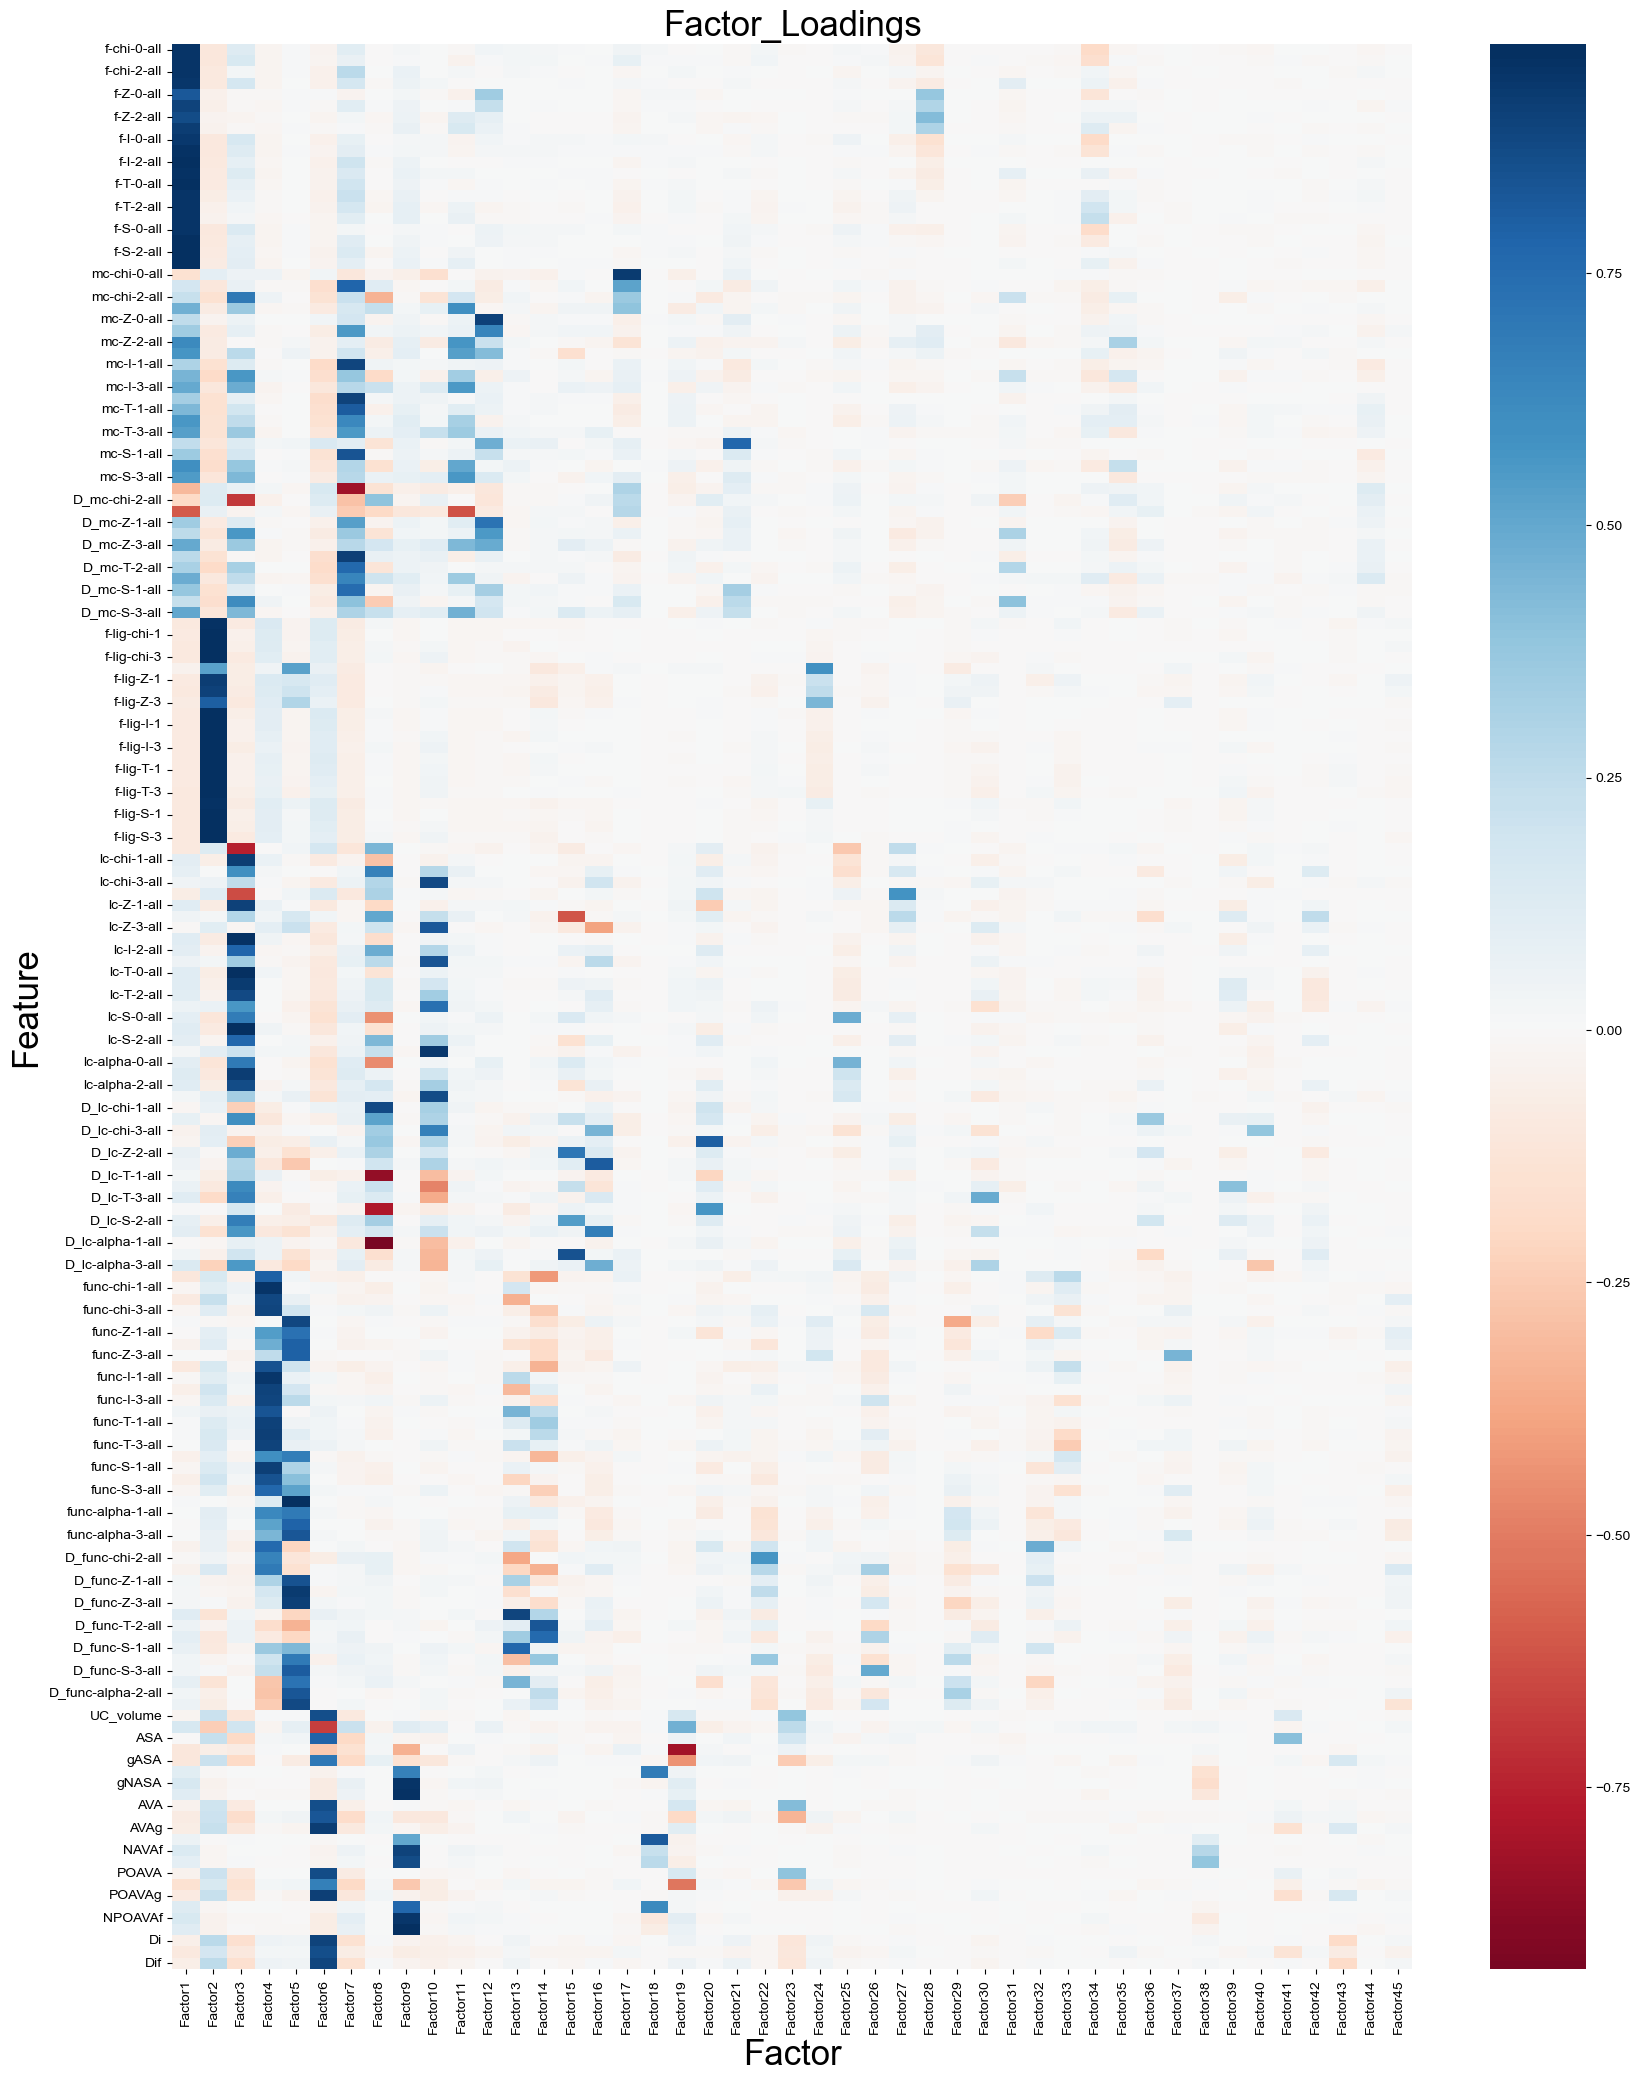

In [10]:
import seaborn as sns
# visualizing factor loadings
plt.figure(figsize=(20, 25))
sns.heatmap(loadings_df, cmap='RdBu', center = 0, annot=False)
plt.title('Factor_Loadings', fontsize=25)
plt.xlabel('Factor', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.show()

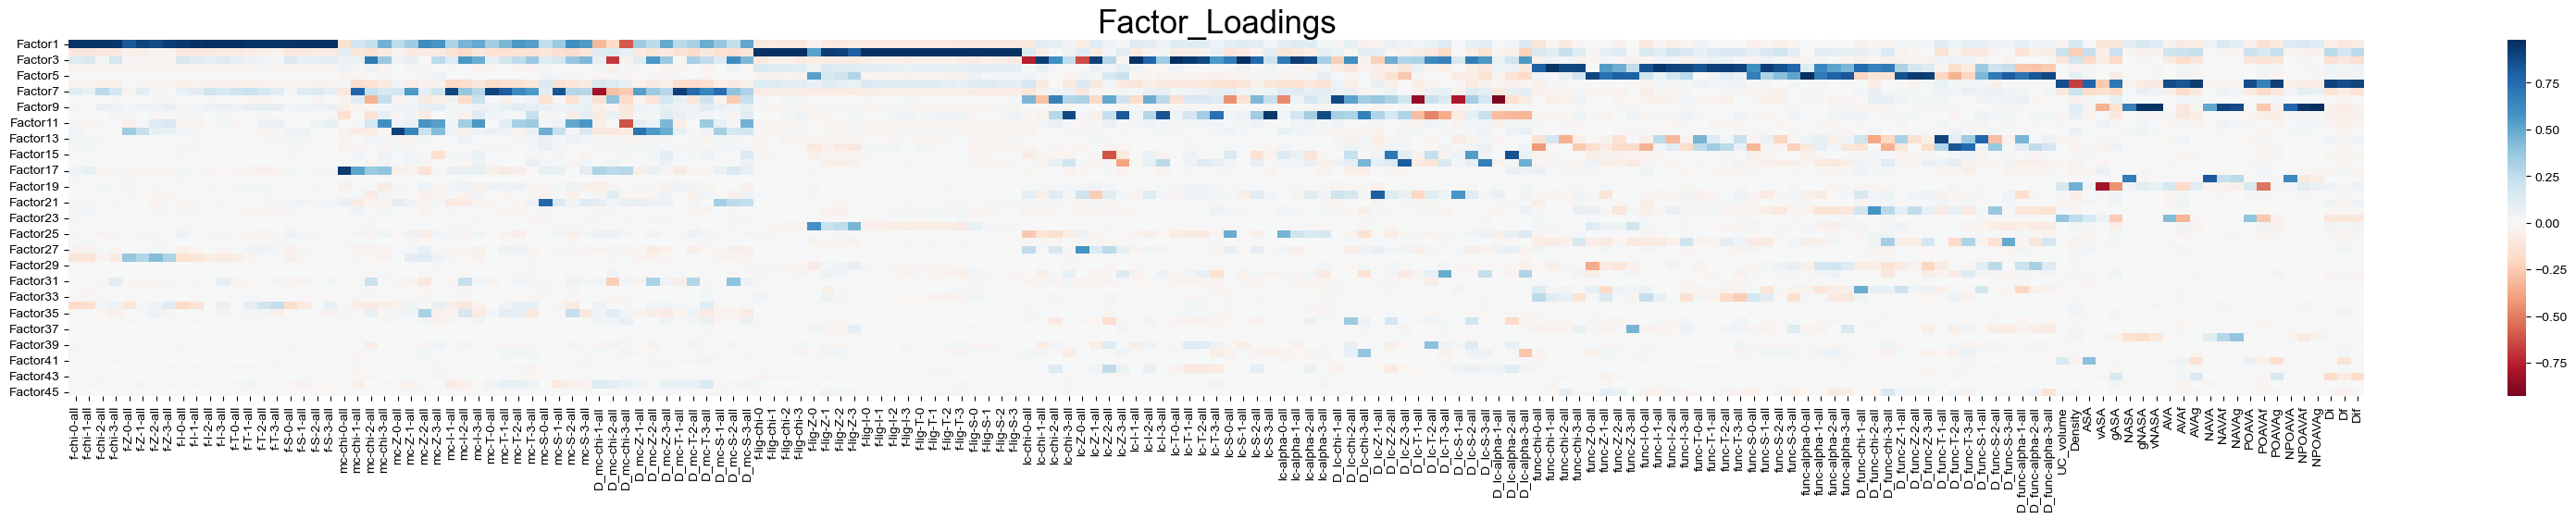

In [11]:
# visualizing factor loadings
plt.figure(figsize=(40, 5))
sns.heatmap(loadings_df.T, cmap='RdBu', center = 0, annot=False)
plt.title('Factor_Loadings', fontsize=25)
plt.show()

In [12]:
framework_desc=[]
mc_desc=[]
lc_desc=[]
func_desc=[]
lig_desc=[]
pore_desc=[]
for descriptor in list(loadings_df.index):
    if 'f-lig' in descriptor:
        lig_desc.append(descriptor)
    elif 'f-' in descriptor:
        framework_desc.append(descriptor)
    elif 'mc-' in descriptor:
        mc_desc.append(descriptor)
    elif 'lc-' in descriptor:
        lc_desc.append(descriptor)
    elif 'func' in descriptor:
        func_desc.append(descriptor)
    else:
        pore_desc.append(descriptor)

In [13]:
from sklearn.preprocessing import MinMaxScaler
loading_values = (loadings_df.values.T)**2
loading_values = pd.DataFrame(loading_values, columns=loadings_df.index)
categorizing_sum = np.zeros((loadings_df.shape[1],6))
for descriptor in list(loadings_df.index):
    if descriptor in framework_desc:
        categorizing_sum[:,0] += np.abs(loading_values[descriptor])
    elif descriptor in mc_desc:
        categorizing_sum[:,1] += np.abs(loading_values[descriptor])
    elif descriptor in lig_desc:
        categorizing_sum[:,2] += np.abs(loading_values[descriptor])
    elif descriptor in lc_desc:
        categorizing_sum[:,3] += np.abs(loading_values[descriptor])
    elif descriptor in func_desc:
        categorizing_sum[:,4] += np.abs(loading_values[descriptor])
    elif descriptor in pore_desc:
        categorizing_sum[:,5] += np.abs(loading_values[descriptor])

categorized_descriptors = {'framework':framework_desc,
                           'mc':mc_desc,
                           'lig':lig_desc,
                           'lc':lc_desc,
                           'func':func_desc,
                           'pore':pore_desc}

In [14]:
dominant_category = []
dominant_weight = []
for i in range(categorizing_sum.shape[0]):
    dominant_category.append(np.argmax(list(categorizing_sum[i])))
    dominant_weight.append(np.max(list(categorizing_sum[i])))

In [15]:
New_factors = []
for i in range(len(categorized_descriptors)):
    for j in range(45):
        if dominant_category[j] == i:
            New_factors.append(loadings_df.columns[j])
new_factor_loading_df = loadings_df[New_factors]

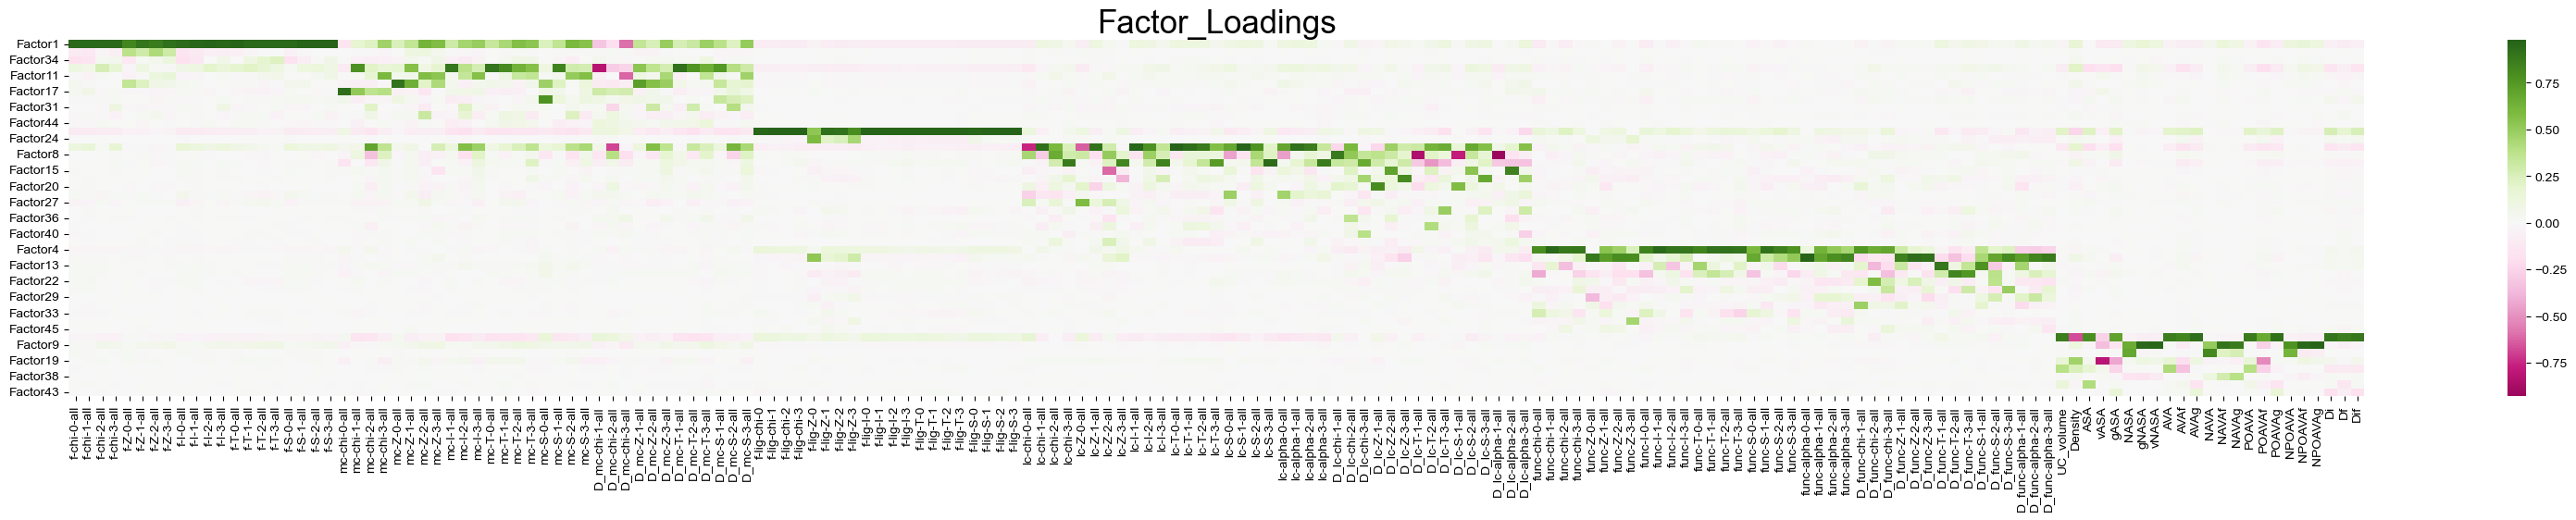

In [16]:
# visualizing factor loadings
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(40, 5))
sns.heatmap(new_factor_loading_df.T, cmap='PiYG', center = 0, annot=False)
plt.title('Factor_Loadings', fontsize=25)
plt.show()

In [17]:
scaler = MinMaxScaler()
categorizing_sum = scaler.fit_transform(categorizing_sum.T).T
categorizing_sum = pd.DataFrame(categorizing_sum, columns=['framework','mc','lc','func','lig','pore'],index=loadings_df.columns)

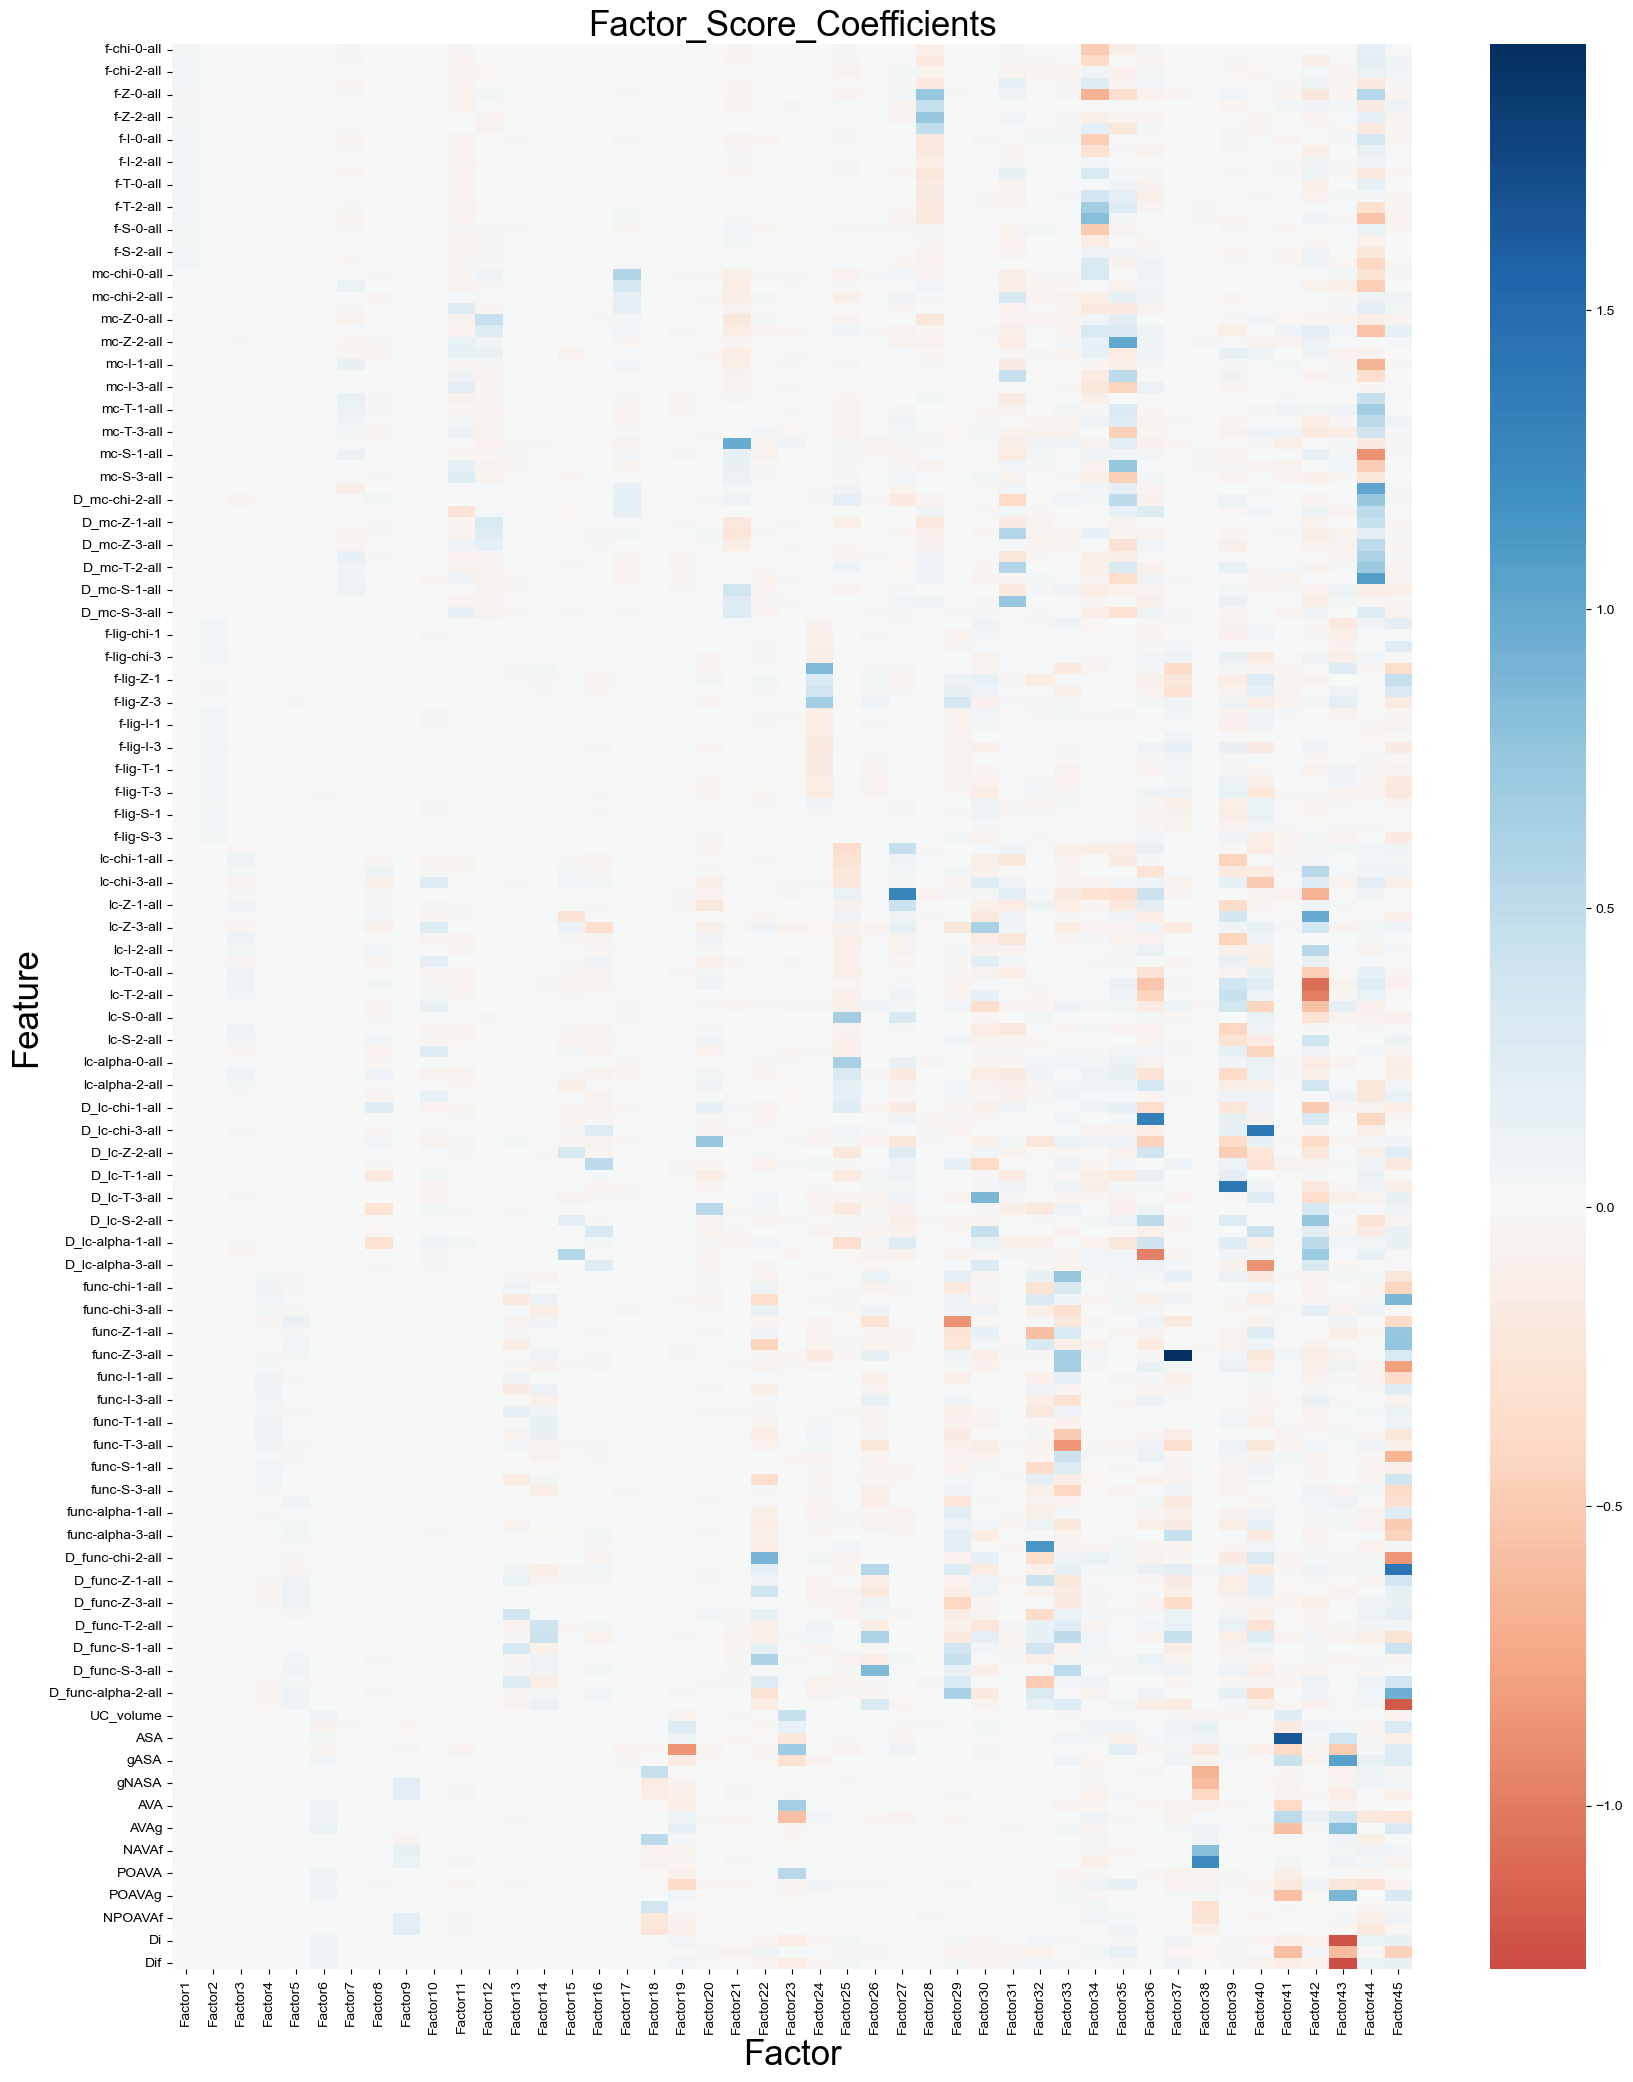

In [18]:
import seaborn as sns
# visualizing factor loadings
plt.figure(figsize=(20, 25))
sns.heatmap(factor_score_coefficients_df, cmap='RdBu', center = 0, annot=False)
plt.title('Factor_Score_Coefficients', fontsize=25)
plt.xlabel('Factor', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.show()

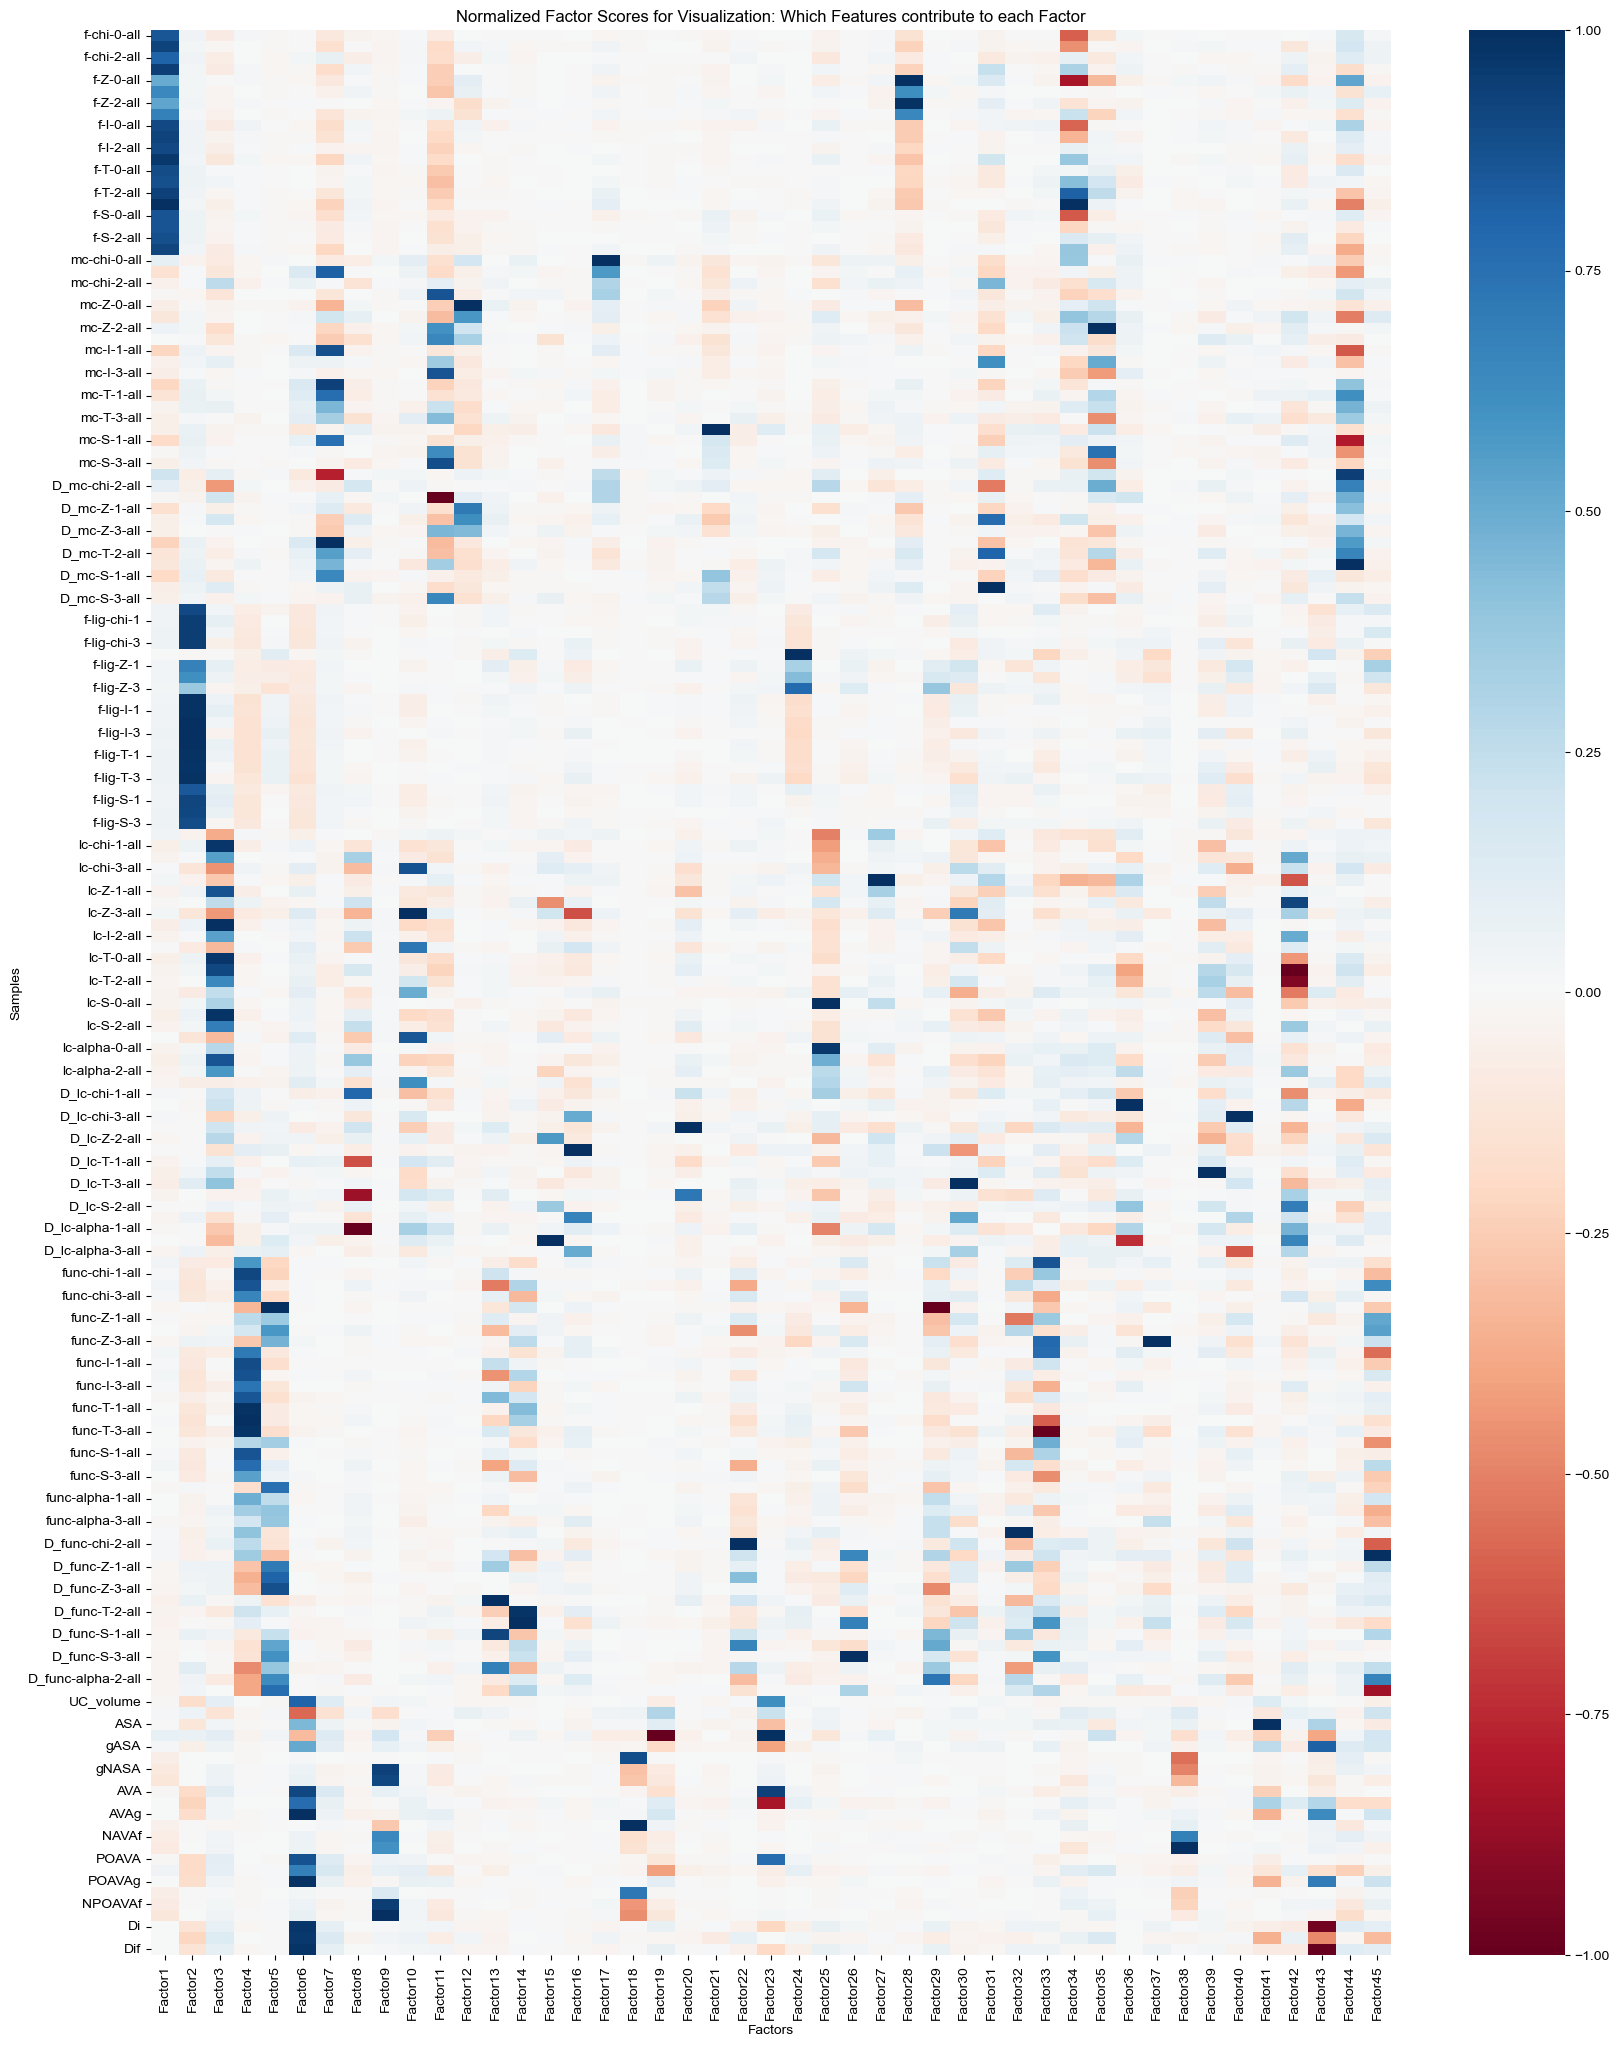

In [19]:
# Step 1: Normalize each column by dividing by the maximum absolute value in each column
normalized_factor_scores_df = factor_score_coefficients_df.apply(lambda x: x / np.max(np.abs(x)), axis=0)

# Step 2: Display the normalized DataFrame
# Visualizing the normalized factor scores

plt.figure(figsize=(20, 25))
sns.heatmap(normalized_factor_scores_df, cmap='RdBu', center=0, annot=False)
plt.title('Normalized Factor Scores for Visualization: Which Features contribute to each Factor')
plt.xlabel('Factors')
plt.ylabel('Samples')
plt.show()

In [20]:
# Now, to apply the transformation to other feature matrices
factor_scores_df = df_standardized.values @ factor_score_coefficients.T              #all MOFs
factor_scores_dfX = dfX_standardized.values @ factor_score_coefficients.T              #MOFs used in this study
factor_scores_dfEMOF = dfEMOF_standardized.values @ factor_score_coefficients.T         #experimentally available MOFs
# Convert the factor scores to a DataFrame for easier handling, with appropriate column names
factor_scores_df = pd.DataFrame(factor_scores_df, columns=[f'Factor{i+1}' for i in range(fa.n_factors)])
factor_scores_dfX = pd.DataFrame(factor_scores_dfX, columns=[f'Factor{i+1}' for i in range(fa.n_factors)], index = MOF_index.values)
factor_scores_dfEMOF = pd.DataFrame(factor_scores_dfEMOF, columns=[f'Factor{i+1}' for i in range(fa.n_factors)])

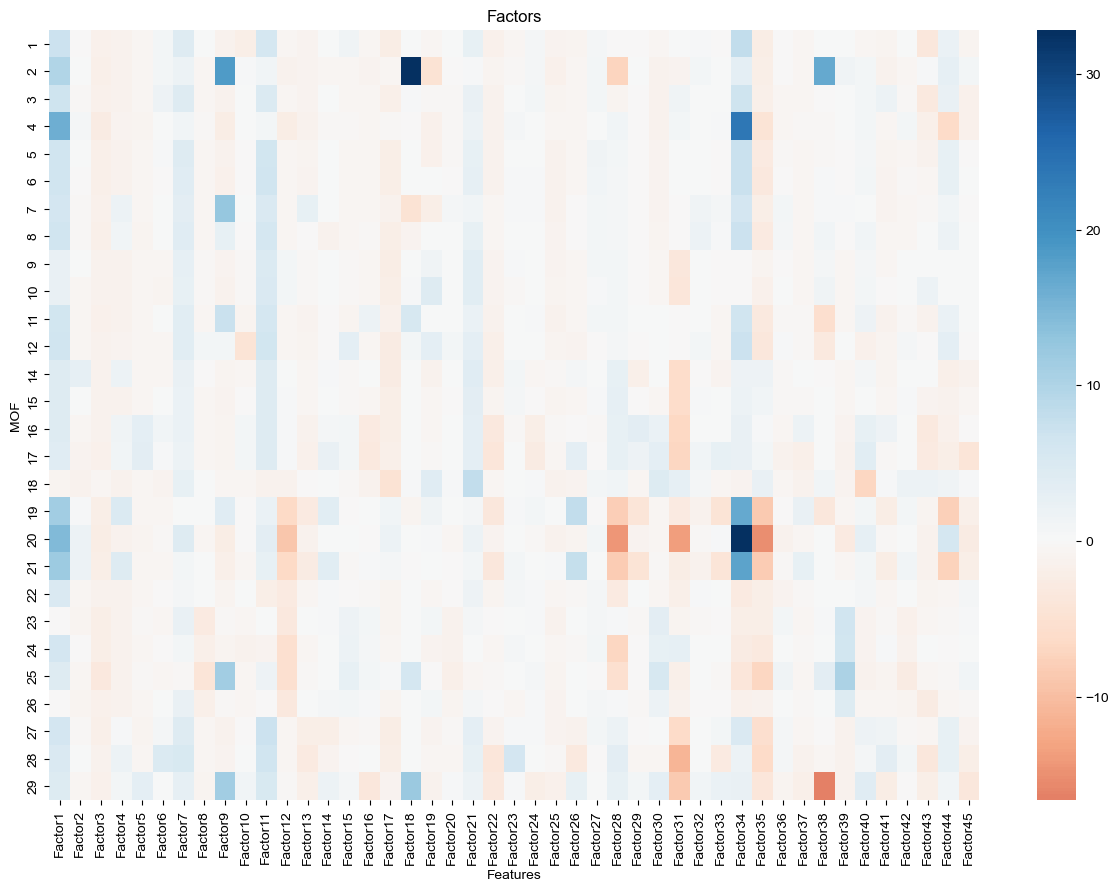

In [21]:
# feature visualization
plt.figure(figsize=(15, 10))
sns.heatmap(factor_scores_dfX, cmap='RdBu', center = 0, annot=False)
plt.title('Factors')
plt.xlabel('Features')
plt.ylabel('MOF')
plt.show()

In [22]:
print(df_standardized.shape)
print(dfX_standardized.shape)
print(factor_score_coefficients.T.shape)

(472494, 171)
(28, 171)
(171, 45)


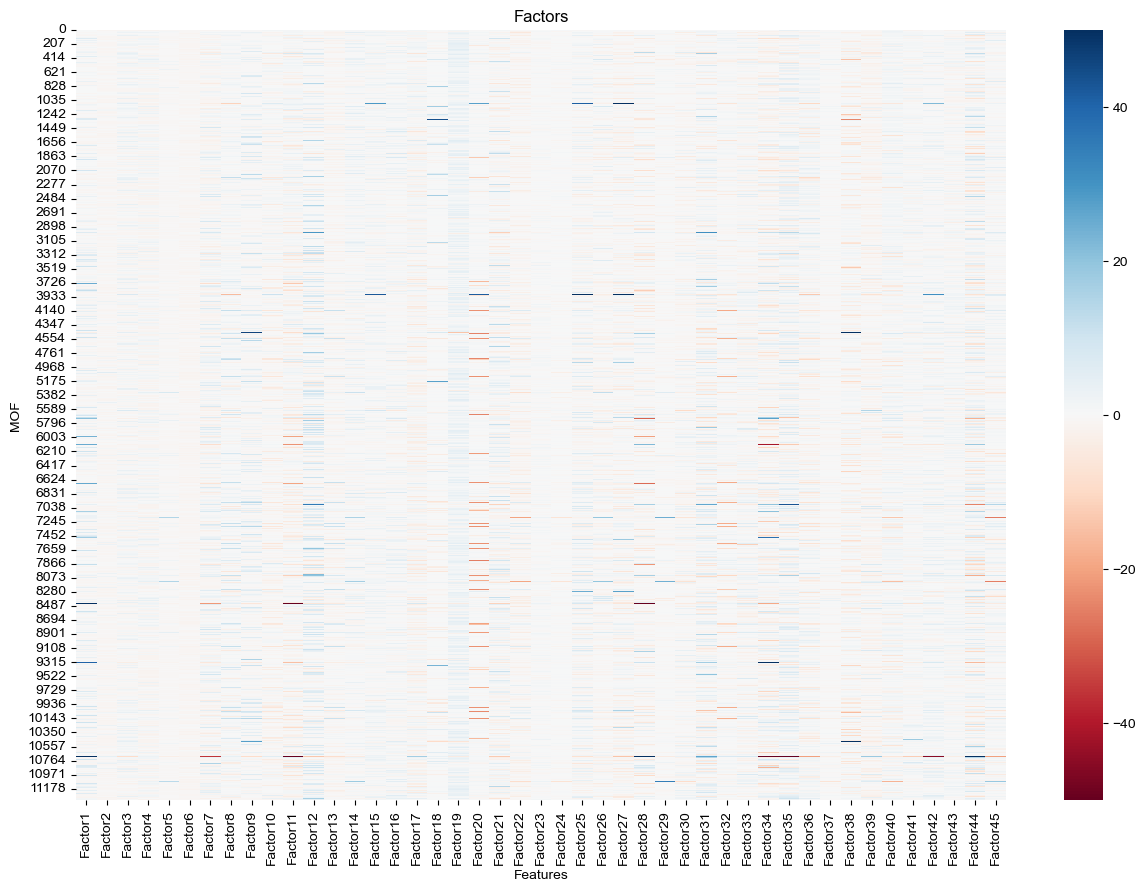

In [23]:
# EMOF visualization
plt.figure(figsize=(15, 10))
sns.heatmap(factor_scores_dfEMOF, cmap='RdBu', center = 0, annot=False, vmin=-50, vmax=50)
plt.title('Factors')
plt.xlabel('Features')
plt.ylabel('MOF')
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import pandas as pd

# Assuming `df` is your DataFrame with the data to be analyzed

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data to standardize it

standardized_allMOF = scaler.fit_transform(factor_scores_df)
standardized_allMOF = pd.DataFrame(standardized_allMOF, columns=factor_scores_df.columns)     #all MOFs

standardized_data = scaler.fit_transform(factor_scores_dfX)
standardized_data = pd.DataFrame(standardized_data, columns=factor_scores_dfX.columns)     #MOFs used in this study

# transformation_matrix = np.linalg.pinv(factor_scores_dfX_removestd_2)@standardized_data
standardized_EMOF = scaler.transform(factor_scores_dfEMOF)
standardized_EMOF = pd.DataFrame(standardized_EMOF, columns=factor_scores_dfX.columns)     # for MOFs experimentally available

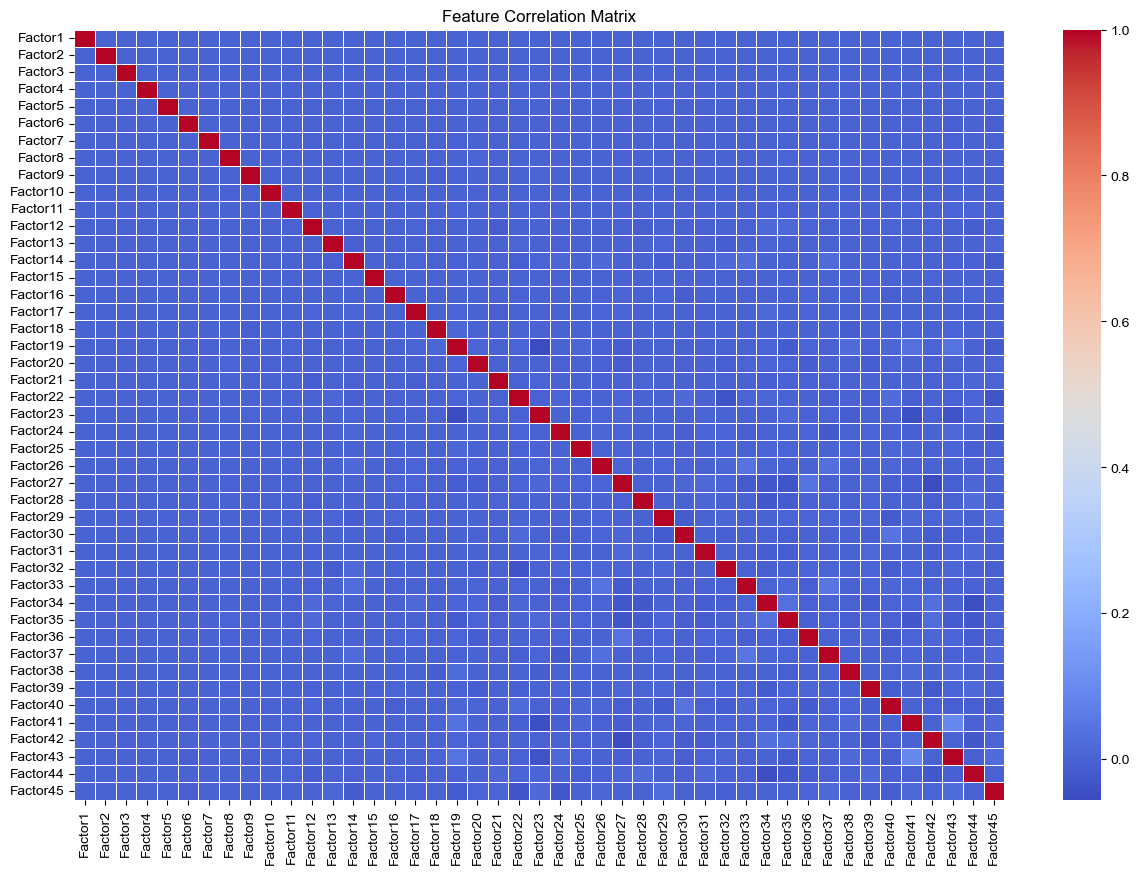

In [25]:
#check for correlation in these parameters
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the 14 data points and 55 features

# Calculate the correlation matrix
corr_matrix = standardized_allMOF.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

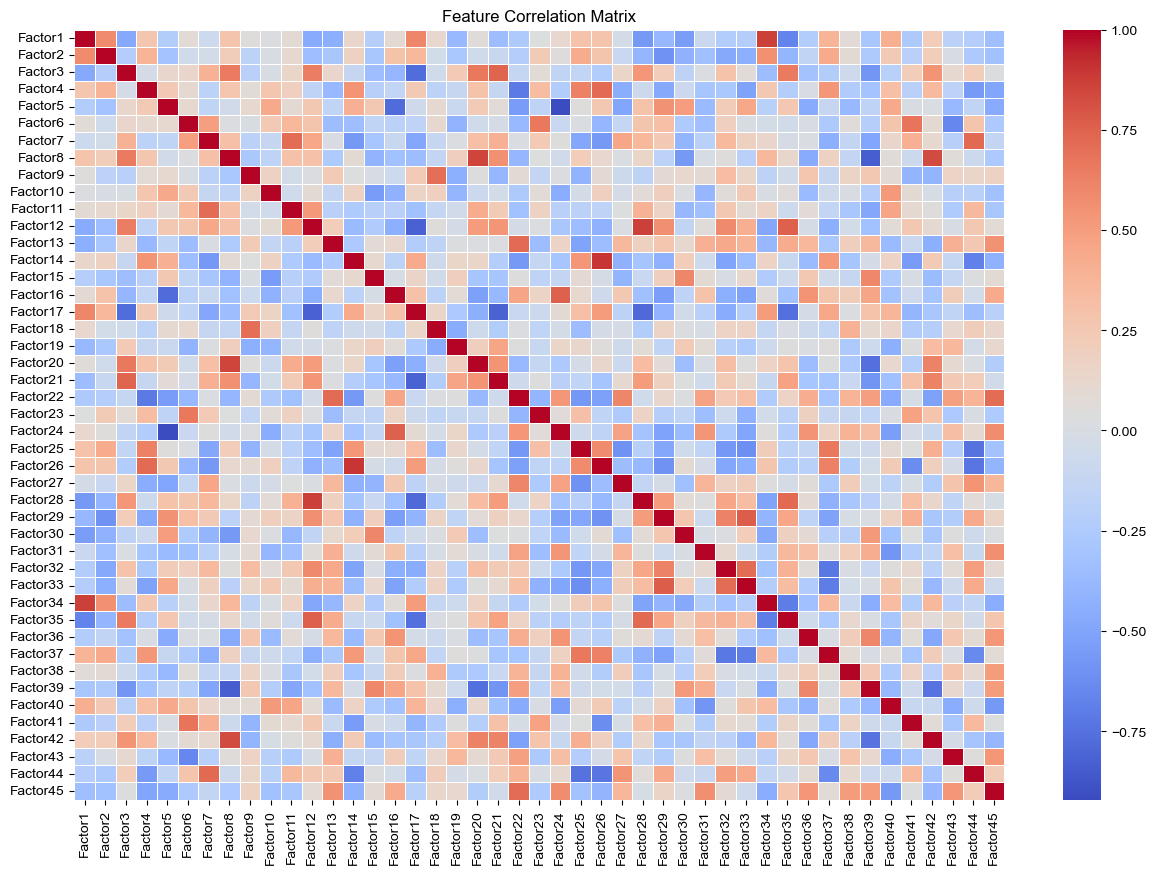

In [26]:
#check for correlation in these parameters

# Assuming 'df' is your DataFrame containing the 14 data points and 55 features

# Calculate the correlation matrix
corr_matrix = standardized_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

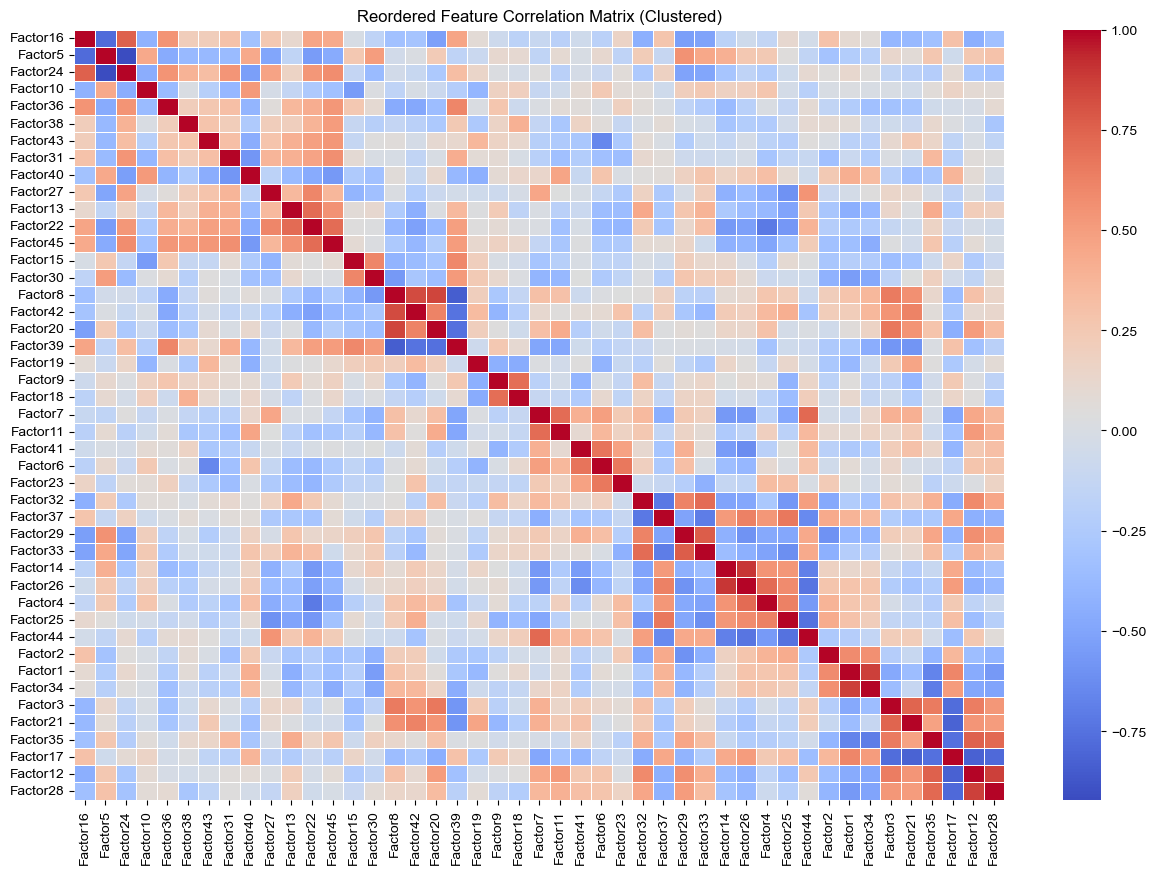

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Assuming 'standardized_data' is your DataFrame containing standardized features

# Step 1: Calculate the correlation matrix
corr_matrix = standardized_data.corr()

# Step 2: Reorder correlation matrix to cluster positive and negative correlations together
# Perform hierarchical clustering on correlation matrix
linkage_matrix = linkage(np.abs(corr_matrix), method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Reorder the correlation matrix
df_reordered = corr_matrix.iloc[ordered_indices, ordered_indices]

# Step 3: Visualize the reordered correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df_reordered, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Reordered Feature Correlation Matrix (Clustered)')
plt.show()

In [28]:
reordered_standardized_data = standardized_data.iloc[:,ordered_indices]
reordered_standardized_data

,Factor16,Factor5,Factor24,Factor10,Factor36,Factor38,Factor43,Factor31,Factor40,Factor27,...,Factor44,Factor2,Factor1,Factor34,Factor3,Factor21,Factor35,Factor17,Factor12,Factor28
0,-0.118033,-0.354498,0.722257,-1.804026,0.057443,0.022234,-1.810390,0.687600,-0.555715,0.395210,...,0.659539,-0.043781,0.277092,0.340368,0.485005,0.237588,0.229392,-0.762634,0.439891,0.161824
1,-0.531247,-0.408419,0.679212,0.836916,-0.070634,3.566154,1.015145,0.410033,0.256791,0.477660,...,0.899686,0.202036,1.000666,-0.281104,0.093272,-1.119342,0.278012,0.629855,0.224041,-1.475091
2,-0.111063,-0.432566,0.891091,0.389198,-0.867064,-0.002656,-1.387856,1.029223,0.265461,0.971374,...,0.696294,-0.228915,0.234624,0.163417,0.155797,0.003072,0.366498,-0.396540,0.544294,0.008014
3,-0.021534,-0.589317,-0.001544,0.385400,-0.510558,-0.035906,-0.572753,0.946337,0.275610,-0.988976,...,-2.066284,0.788916,2.599726,2.210043,-1.574579,-0.324868,-0.357023,0.843645,-0.275977,0.487040
4,-0.010211,-0.405496,0.244348,0.186157,-0.176007,-0.027924,-0.163467,0.741188,0.033332,1.893180,...,0.744977,0.334458,0.184972,0.221213,0.065246,0.276743,0.071147,-0.608425,0.452810,0.385110
5,-0.062751,-0.424534,0.461503,0.170347,-0.057617,0.105277,0.277352,0.721345,0.182274,1.512981,...,0.759112,-0.173530,0.175077,0.229431,-0.158286,0.332673,-0.070218,-0.501359,0.483673,0.373180
6,-0.094914,-0.303319,0.436915,0.405462,1.627761,0.117759,0.475195,0.635790,-0.120055,0.673923,...,0.317827,-0.320091,0.029757,0.066235,0.267978,-0.671404,0.239150,0.119807,0.515459,0.378762
7,0.116270,-0.544625,0.306870,0.164584,1.223307,0.271277,0.819129,0.677459,0.306531,1.107798,...,0.537043,-0.374235,0.144101,0.182441,-0.106606,0.101460,0.041538,-0.418647,0.495171,0.359929
8,-0.030387,-0.300858,0.060311,0.104642,-0.041074,0.156438,0.931729,-0.268562,0.053472,0.525524,...,-0.015676,0.015916,-0.914949,-0.687776,0.842832,0.815308,0.638694,-0.751534,1.065440,0.457360
9,-0.110597,-0.321682,0.239175,0.105363,0.160817,0.333037,2.083997,-0.288603,0.226838,-0.090377,...,0.010283,-0.511843,-0.925625,-0.676820,0.614655,0.858493,0.452353,-0.620314,1.095691,0.447365


In [29]:
pd.concat((standardized_EMOF, standardized_data))

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,...,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45
0,-1.584761,-0.120129,3.885005,-0.285888,-0.121083,-1.272239,-2.052324,1.503438,0.299937,-0.229673,...,-0.934849,0.392464,-0.765118,-0.531345,0.218118,0.547121,0.440305,1.193952,0.000849,0.609653
1,-1.124017,-0.177410,5.857738,0.847272,0.044503,-0.918639,-1.037702,1.769138,0.024215,-0.464329,...,1.435276,0.557073,-0.570592,-0.410174,0.214228,0.682537,0.419155,1.462634,0.305527,0.365256
2,-1.554950,-0.433501,3.874957,-0.288197,-0.102207,-0.867994,-1.342305,0.963981,0.390633,0.158325,...,1.169032,0.398736,-1.063350,-0.419360,0.123602,0.794345,0.213031,0.563449,0.749945,0.607330
3,-1.753200,-0.640244,6.570813,1.164696,0.256412,-1.157853,-2.757657,2.309022,-0.348890,-0.854517,...,-1.714782,0.238003,0.249591,-0.643594,-0.000827,0.463138,0.778563,1.220730,0.176776,0.293623
4,-1.304249,-1.098999,1.962893,-0.721138,-0.218638,0.009399,-2.865573,0.569294,-0.343950,0.584441,...,-0.497310,0.157779,0.006961,-0.142911,-0.258310,1.074951,0.292228,0.191099,-0.272852,0.851104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,-0.426971,-0.447516,-3.195921,-0.696620,-0.131641,-0.783025,-2.248179,-3.519594,1.798035,-0.344366,...,2.288437,-0.149977,0.734372,3.436955,-0.988341,-0.426431,-2.809426,0.235687,-0.150503,1.462455
24,-1.566058,-0.998828,0.147123,-0.734611,-0.156181,-0.157315,-0.230624,-1.314252,-0.356743,-0.071549,...,0.617859,-0.051399,0.093818,1.370042,-0.646206,-0.066612,-0.946439,-1.093195,-0.206654,0.343847
25,0.035796,-0.243908,-0.124717,0.345263,-0.592806,0.422850,1.113878,0.042083,-0.561468,0.148267,...,1.170428,-0.427070,0.016296,-0.621706,0.582161,1.364803,-0.267684,0.236548,0.802186,-0.278237
26,-0.251592,0.356793,0.597261,1.085091,-0.456058,4.157689,1.829564,-0.094064,-0.485620,0.440247,...,0.991287,-1.062181,-0.086980,-0.653638,0.066974,3.125527,1.162910,-1.860776,0.826279,-1.029581


In [30]:
import os
from sklearn.manifold import TSNE

all_standard_data = pd.concat((standardized_allMOF, standardized_data))

# Apply tSNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=46)
tsne_results = tsne.fit_transform(all_standard_data)

In [31]:
cif_names = ["DB12-HOJNOL_clean.cif", "DB12-REYMOZ_freeONLY.cif", "DB12-TETZID_clean.cif", "DB14-pizsau_P1.cif", "DB14-vidcod_P1.cif"]

In [32]:
red_index = []
for cif_temp in cif_names:
    red_index.append(np.where(merged_df["filename"].values == cif_temp)[0])
red_index = np.array(red_index).flatten()

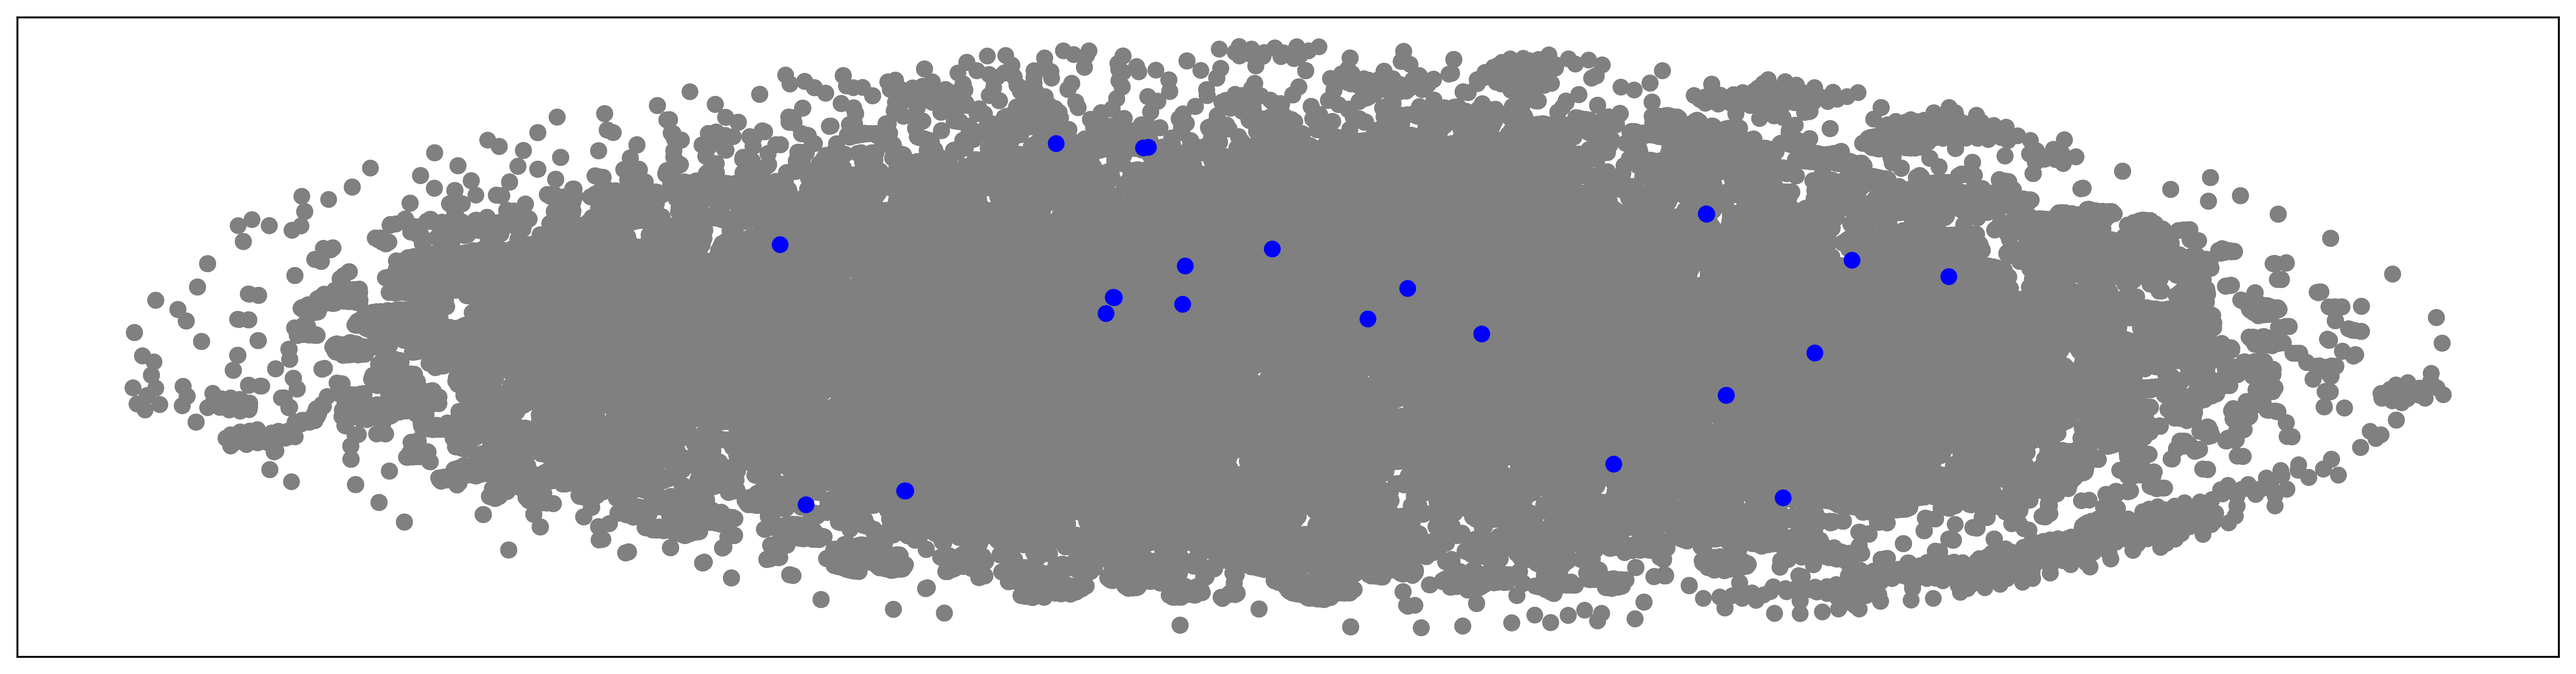

In [33]:
# Visualize UMAP results with different colors
plt.figure(figsize=(15, 4), dpi = 600)

plt.scatter(x = tsne_results[:,0], y = tsne_results[:,1], color = "gray")

plt.scatter(x = tsne_results[-len(standardized_data):,0], y = tsne_results[-len(standardized_data):,1], color = "blue")

# plt.scatter(x = tsne_results[:,0][red_index], y = tsne_results[:,1][red_index], color = "red")


plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.show()

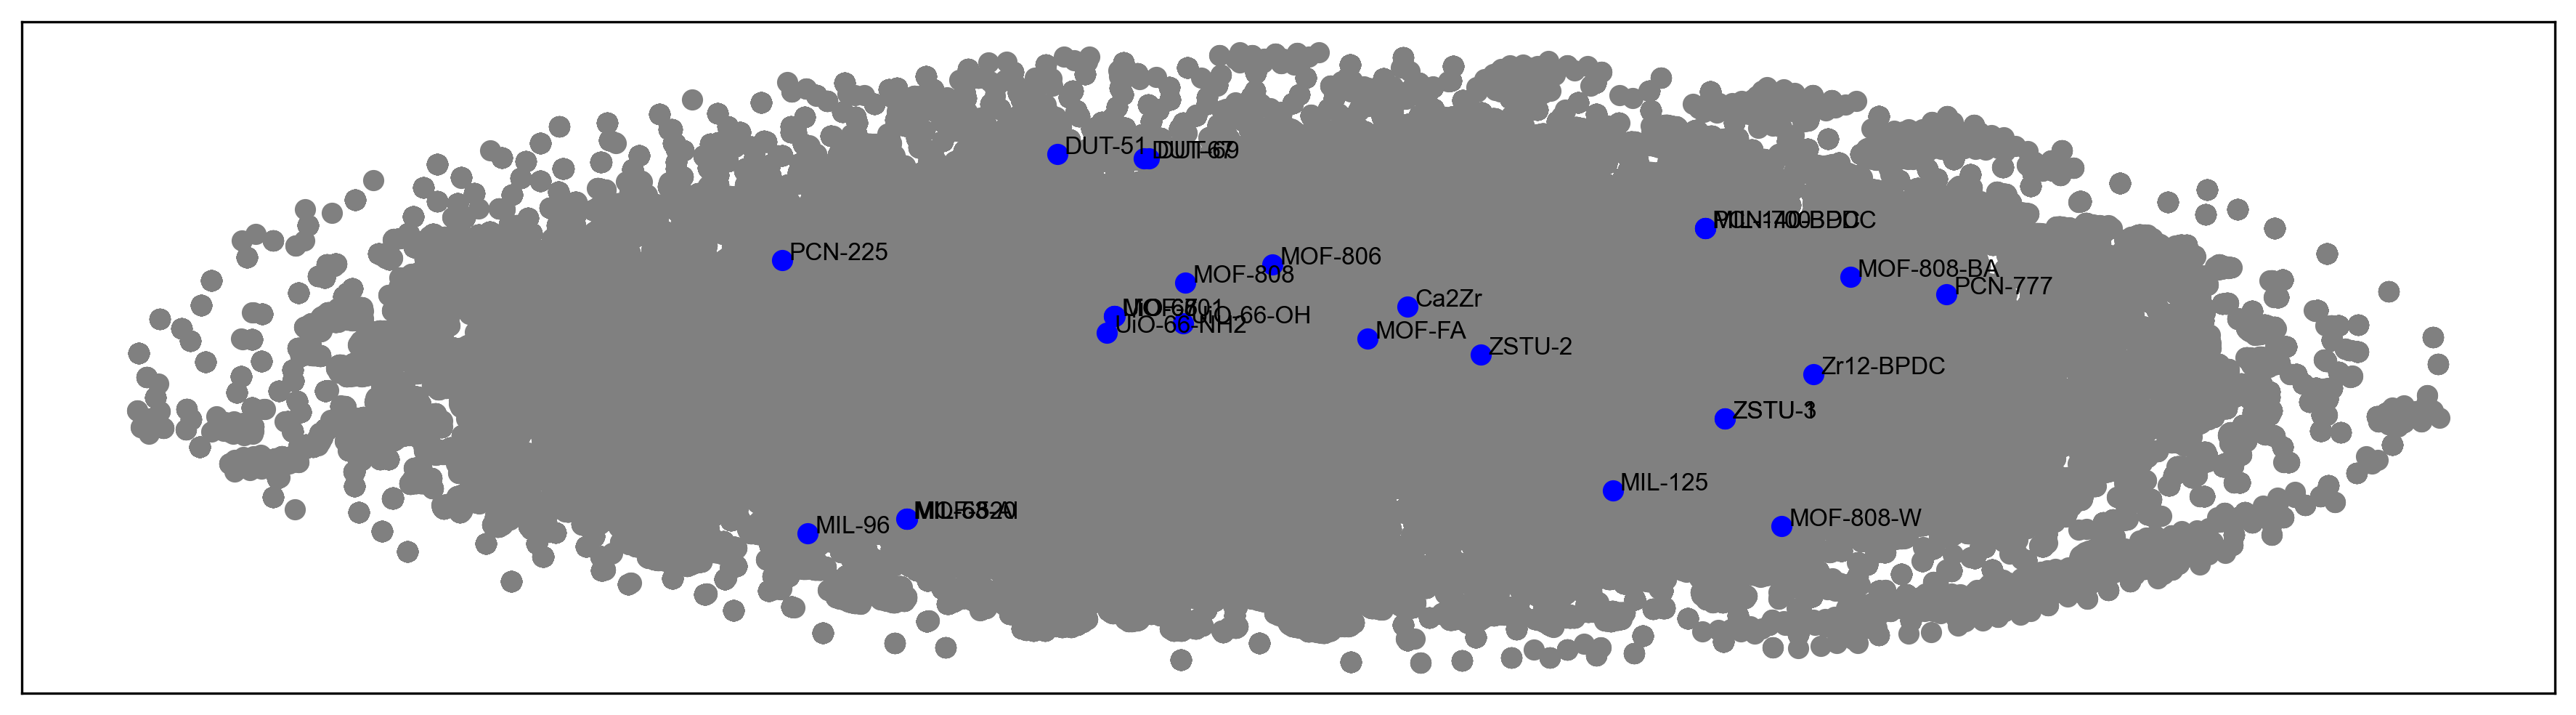

In [34]:
plt.figure(figsize=(15, 4), dpi=300)

# Plot all data points in gray
plt.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], color="gray")

# Plot subset in blue
subset_x = tsne_results[-len(standardized_data):, 0]
subset_y = tsne_results[-len(standardized_data):, 1]
plt.scatter(x=subset_x, y=subset_y, color="blue")

# Add labels next to blue points
for i, (x, y) in enumerate(zip(subset_x, subset_y)):
    plt.text(x + 1, y, f'{MOF_name[i]}', fontsize=8)  # adjust offset as needed

# plt.xlabel('tSNE Component 1', fontsize=15)
# plt.ylabel('tSNE Component 2', fontsize=15)
# plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

In [36]:
MOF_name

0          MOF-808
1       MOF-808-BA
2        MOF-808-W
3        Zr12-BPDC
4           UiO-67
5           UiO-66
6       UiO-66-NH2
7        UiO-66-OH
8     MIL-140-BPDC
9      MIL-140-BDC
10         MOF-801
11          MOF-FA
12         PCN-225
13         PCN-700
14          DUT-51
15          DUT-67
16           Ca2Zr
17          ZSTU-1
18          ZSTU-2
19          ZSTU-3
20         MIL-125
21          MIL-53
22         MOF-520
23          MIL-96
24       MIL-68-Al
25         MOF-806
26         PCN-777
27          DUT-69
Name: MOF, dtype: object

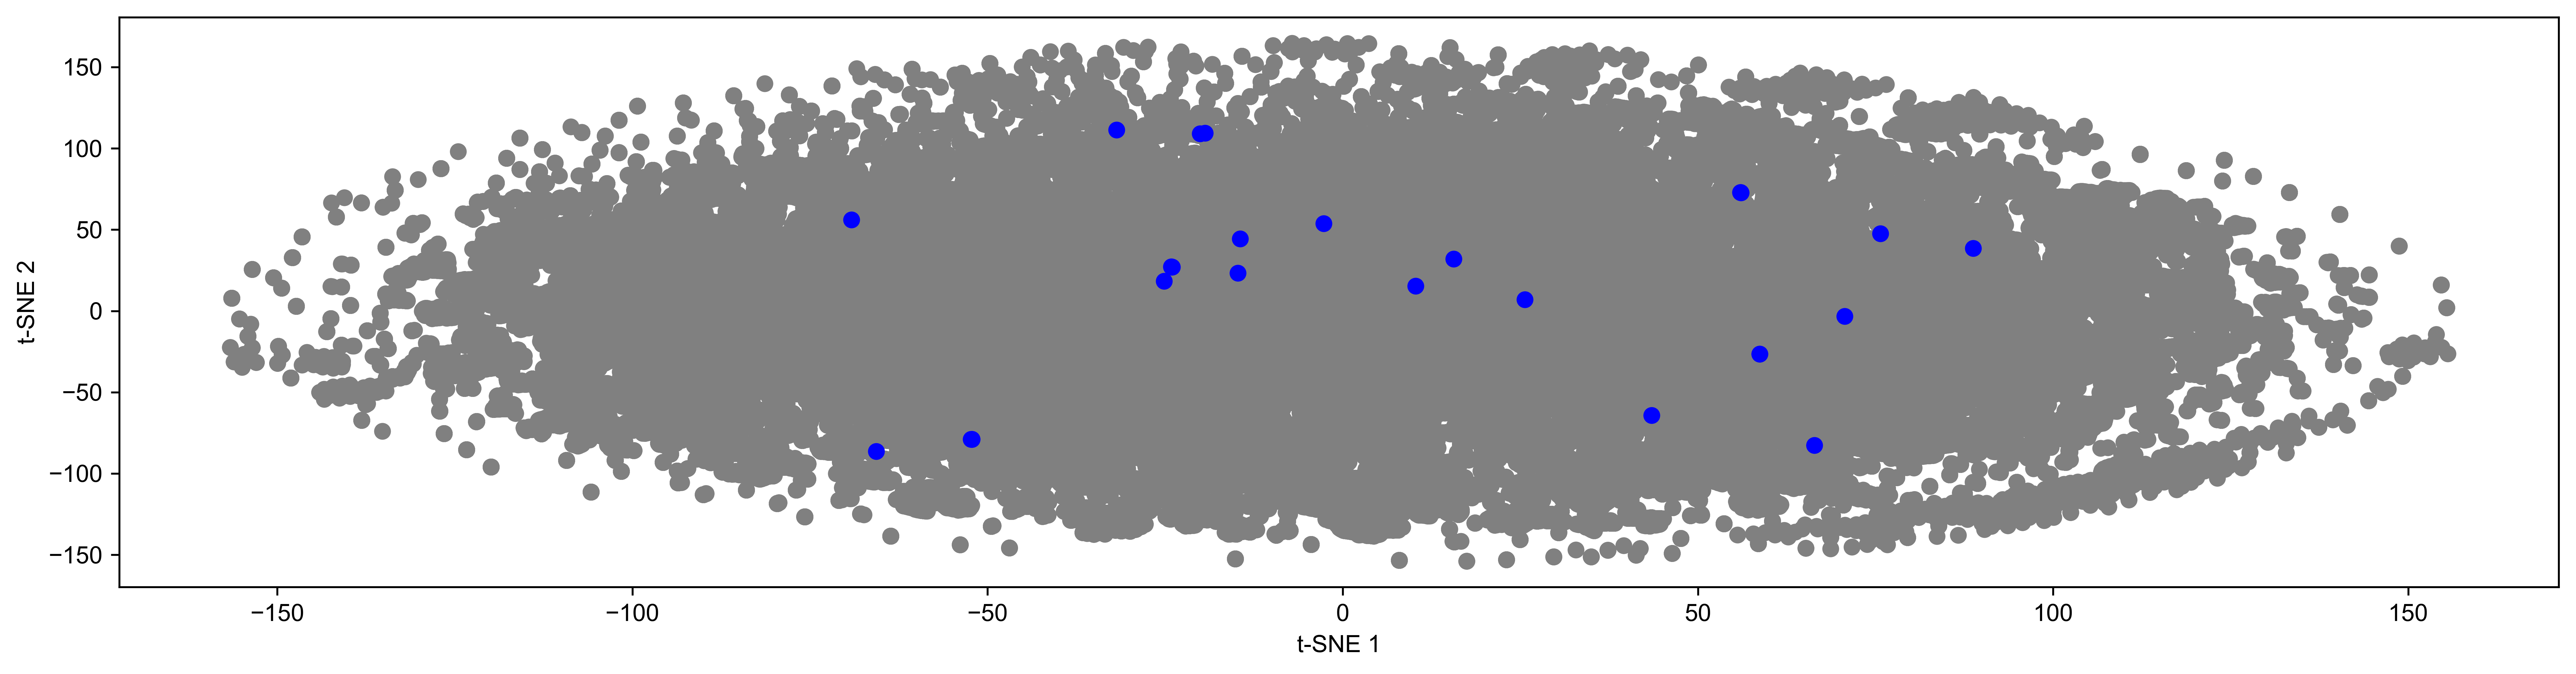

In [38]:
# Visualize UMAP results with different colors
plt.figure(figsize=(15, 4), dpi = 600)

plt.scatter(x = tsne_results[:,0], y = tsne_results[:,1], color = "gray")

plt.scatter(x = tsne_results[-len(standardized_data):,0], y = tsne_results[-len(standardized_data):,1], color = "blue")

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()

plt.show()